In [2]:
# Silence TF logs & pick one GPU (optional)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # set "" to force CPU

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Core libs
import numpy as np
import matplotlib.pyplot as plt

# Sionna
import sionna
from sionna.phy.constants import BOLTZMANN_CONSTANT as kB
from sionna.phy.utils import log2
from sionna.phy.channel.tr38901 import UMi, UMa, PanelArray
from sionna.phy.channel import GenerateOFDMChannel
from sionna.phy.ofdm import ResourceGrid
from sionna.phy.mimo import StreamManagement

# Sionna precision & seed
sionna.phy.config.precision = 'single'
sionna.phy.config.seed = 123
print("Imports OK.")


ModuleNotFoundError: No module named 'sionna'

In [28]:
# Antennas & users
Nt    = 8     # BS antennas  (↔ \Nt)
Ktot  = 12    # total users   (↔ \Ktot)
Umax  = 2     # max users per RB
Rmax  = 1     # one RB per user per slot

# OFDM grid & RBs
fft_size           = 96           # total subcarriers
subcarrier_spacing = 15e3         # Hz
N_sc_per_RB        = 12           # subcarriers per RB
assert fft_size % N_sc_per_RB == 0
NRB  = fft_size // N_sc_per_RB    # (↔ \NRB)
BRB  = N_sc_per_RB * subcarrier_spacing  # (↔ \BRB)

num_ofdm_symbols = 10
batch_size       = 1
temperature      = 294.0  # K

# Downlink power
bs_power_dbm = 46.0                      # e.g., 40 W EIRP ≈ 46 dBm
Ptot         = 10**((bs_power_dbm-30)/10)  # W   (↔ \Ptot)
Pmax_RB      = Ptot / NRB

# Noise
N0        = kB * temperature           # W/Hz (↔ \Nzer)
sigma2_sc = N0 * subcarrier_spacing    # per-subcarrier noise
sigma2_RB = N0 * BRB                   # per-RB noise (↔ σ² = N0*BRB)

# 3GPP channel scenario
scenario  = 'umi'      # 'umi' or 'uma'
o2i_model = 'low'      # 'low' or 'high'
direction = 'downlink' # 'downlink' or 'uplink'

print(f"NRB={NRB}, BRB={BRB/1e3:.1f} kHz, Ptot={Ptot:.2f} W, sigma2_RB={sigma2_RB:.2e} W")


NRB=8, BRB=180.0 kHz, Ptot=39.81 W, sigma2_RB=7.31e-16 W


In [29]:
# BS array with 38.901 element pattern (ensure enough antenna ports)
bs_array = PanelArray(
    num_rows_per_panel=2,
    num_cols_per_panel=2,
    polarization='dual',
    polarization_type='VH',
    antenna_pattern='38.901',
    carrier_frequency=3.5e9
)
assert bs_array.num_ant >= Nt, f"bs_array.num_ant={bs_array.num_ant} < Nt={Nt}"

# UT array: single-antenna omni
ut_array = PanelArray(
    num_rows_per_panel=1,
    num_cols_per_panel=1,
    polarization='single',
    polarization_type='V',
    antenna_pattern='omni',
    carrier_frequency=3.5e9
)
print(f"BS ports={bs_array.num_ant}, UT ports={ut_array.num_ant}")


BS ports=8, UT ports=1


In [30]:
# One BS at origin, K users uniformly in an annulus
d_min, d_max = 20.0, 250.0  # meters
angles = 2*np.pi*np.random.rand(Ktot)
radii  = np.sqrt(np.random.rand(Ktot))*(d_max - d_min) + d_min

ut_xy  = np.stack([radii*np.cos(angles), radii*np.sin(angles)], axis=-1).astype(np.float32)
ut_z   = np.random.uniform(1.5, 2.0, size=(Ktot,1)).astype(np.float32)
ut_loc = np.concatenate([ut_xy, ut_z], axis=-1).astype(np.float32)   # [K,3]
bs_loc = np.array([[0.0, 0.0, 10.0]], dtype=np.float32)              # [1,3]

# Orientations (yaw,pitch,roll in degrees)
ut_orient = np.zeros((Ktot, 3), dtype=np.float32)
bs_orient = np.zeros((1, 3), dtype=np.float32)

# Velocities (m/s)
ut_vel = np.zeros((Ktot, 3), dtype=np.float32)

# Convert to TF tensors WITH batch dim and correct dtypes
ut_loc_b     = tf.convert_to_tensor(ut_loc[None, ...],    dtype=tf.float32)  # [B,K,3]
bs_loc_b     = tf.convert_to_tensor(bs_loc[None, ...],    dtype=tf.float32)  # [B,1,3]
ut_orient_b  = tf.convert_to_tensor(ut_orient[None, ...], dtype=tf.float32)  # [B,K,3]
bs_orient_b  = tf.convert_to_tensor(bs_orient[None, ...], dtype=tf.float32)  # [B,1,3]
ut_vel_b     = tf.convert_to_tensor(ut_vel[None, ...],    dtype=tf.float32)  # [B,K,3]

# Indoor state MUST be boolean with batch dimension
in_state_b = tf.zeros((batch_size, Ktot), dtype=tf.bool)  # False=outdoor

# LOS mask: None = let model sample LOS/NLOS
los_mask = None
# To force LOS for all users, use:
# los_mask = tf.ones((batch_size, Ktot), dtype=tf.bool)

print("Topology tensors ready.")


Topology tensors ready.


In [31]:
if scenario == 'umi':
    channel_model = UMi(
        carrier_frequency=3.5e9,
        o2i_model=o2i_model,
        ut_array=ut_array,
        bs_array=bs_array,
        direction=direction,
        enable_pathloss=True,
        enable_shadow_fading=True
    )
elif scenario == 'uma':
    channel_model = UMa(
        carrier_frequency=3.5e9,
        o2i_model=o2i_model,
        ut_array=ut_array,
        bs_array=bs_array,
        direction=direction,
        enable_pathloss=True,
        enable_shadow_fading=True
    )
else:
    raise ValueError("scenario must be 'umi' or 'uma'")

channel_model.set_topology(
    ut_loc_b, bs_loc_b, ut_orient_b, bs_orient_b, ut_vel_b, in_state_b, los_mask
)

print(f"{scenario.upper()} channel model created & topology set.")


UMI channel model created & topology set.


In [32]:
resource_grid = ResourceGrid(
    num_ofdm_symbols=num_ofdm_symbols,
    fft_size=fft_size,
    subcarrier_spacing=subcarrier_spacing,
    num_tx=1,                 # single BS
    num_streams_per_tx=Nt     # we will use first Nt TX ports
)

gen_ofdm = GenerateOFDMChannel(channel_model, resource_grid)

# h_freq: [B, num_rx, n_rx_ant, num_tx, n_tx_ant, T, F]
h_freq = gen_ofdm(batch_size)
print("h_freq shape:", h_freq.shape)

# Sanity: expect num_rx=Ktot, n_rx_ant=1, num_tx=1
B, num_rx, n_rx_ant, num_tx, n_tx_ant, T, F = h_freq.shape
assert num_rx == Ktot and n_rx_ant == 1 and num_tx == 1, "Unexpected dims!"


h_freq shape: (1, 12, 1, 1, 8, 10, 96)


In [33]:
# Average across OFDM symbols (time) and across subcarriers within RB
# Keep first Nt BS ports if the panel has more
h_f = tf.reduce_mean(h_freq, axis=-2)       # avg over time: [B,K,1,1,n_tx_ant,F]
h_f = h_f[..., :Nt, :]                      # first Nt ports: [B,K,1,1,Nt,F]

# Group subcarriers into RBs
h_f = tf.reshape(h_f, (B, Ktot, 1, 1, Nt, NRB, N_sc_per_RB))
h_rb = tf.reduce_mean(h_f, axis=-1)         # avg in freq: [B,K,1,1,Nt,NRB]

# Reorder to [B, NRB, K, Nt]
h_rb = tf.squeeze(h_rb, axis=[2,3])         # [B,K,Nt,NRB]
h_rb = tf.transpose(h_rb, perm=[0,3,1,2])   # [B,NRB,K,Nt]
print("h_rb shape:", h_rb.shape, "  (per RB user channel vectors)")


h_rb shape: (1, 8, 12, 8)   (per RB user channel vectors)


In [36]:
def unit_norm(v, eps=1e-9):
    """
    v: complex tensor [..., Nt]
    Returns v scaled to unit L2 norm per row. Uses a real-valued norm to avoid
    tf.maximum on complex types.
    """
    v = tf.cast(v, tf.complex64)
    # Real-valued L2 norm: sqrt(sum(|v|^2))
    # |v|^2 = real(v * conj(v))
    power = tf.math.real(v * tf.math.conj(v))                  # [..., Nt]
    n = tf.sqrt(tf.reduce_sum(power, axis=-1, keepdims=True))  # [..., 1] (float32)
    n = tf.maximum(n, tf.constant(eps, dtype=n.dtype))         # clamp
    return v / tf.cast(n, tf.complex64)

def rzf_directions(Hn, alpha=1e-3):
    """
    Hn: [U_n, Nt] complex  -> returns V: [U_n, Nt] unit-norm rows
    """
    H  = tf.cast(Hn, tf.complex64)
    HH = tf.transpose(tf.math.conj(H))        # [Nt, U_n]
    A  = tf.matmul(H, HH) + alpha*tf.eye(tf.shape(H)[0], dtype=H.dtype)
    Vt = tf.matmul(HH, tf.linalg.inv(A))      # [Nt, U_n]
    V  = tf.transpose(Vt)                     # [U_n, Nt]
    return unit_norm(V)

def greedy_assign(h_rb, Umax, Rmax=1):
    """
    h_rb: [B,NRB,K,Nt] complex (tf.Tensor)
    Returns A: [B,NRB,K] {0,1}, at most Umax per RB and Rmax per user.
    Greedy by ||h|| strength per (u,n).
    """
    B, NRB, K, Nt = h_rb.shape
    A = np.zeros((B, NRB, K), dtype=np.int32)
    used = np.zeros((B, K), dtype=np.int32)
    score = tf.reduce_sum(tf.abs(h_rb)**2, axis=-1).numpy() / float(sigma2_RB)  # [B,NRB,K]
    for b in range(B):
        for n in range(NRB):
            order = np.argsort(-score[b,n,:])
            cnt = 0
            for u in order:
                if used[b,u] < Rmax and cnt < Umax:
                    A[b,n,u] = 1
                    used[b,u] += 1
                    cnt += 1
    return A

# Assignments
A = greedy_assign(h_rb, Umax=Umax, Rmax=Rmax)      # [B,NRB,K]

# Convert channels to NumPy for advanced indexing
h_rb_np = h_rb.numpy()

# Beam directions (RZF) per RB
B0, NRB0, K0, Nt0 = h_rb_np.shape
V = np.zeros((B0, NRB0, K0, Nt0), dtype=np.complex64)
for b in range(B0):
    for n in range(NRB0):
        users = np.where(A[b,n]==1)[0]            # NumPy indices
        if len(users)==0:
            continue
        Hn = h_rb_np[b, n, users, :]              # [U_n, Nt] complex64
        Vn = rzf_directions(Hn, alpha=1e-3).numpy()
        for i,u in enumerate(users):
            V[b,n,u,:] = Vn[i]

# Power split (uniform per RB, capped)
P = np.zeros((B0, NRB0, K0), dtype=np.float32)
for b in range(B0):
    for n in range(NRB0):
        Us = int(A[b,n].sum())
        if Us > 0:
            prb = min(Pmax_RB, Ptot/NRB)
            P[b,n,A[b,n]==1] = prb/Us

print("A (assign), V (beams), P (powers) ready. (Complex norm bug fixed)")


A (assign), V (beams), P (powers) ready. (Complex norm bug fixed)


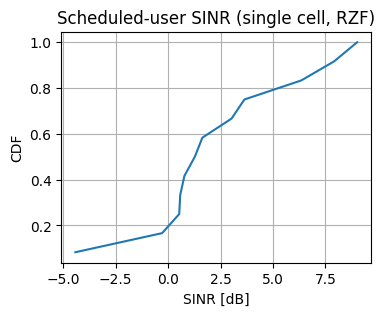

Decomposition ready in `parts` (keys: desired, intra, inter, noise, SINR).


In [37]:
def sinr_per_user(h_rb, A, V, P, sigma2_RB, intercell_power=0.0):
    """
    h_rb: [B,NRB,K,Nt] complex
    A:    [B,NRB,K]    {0,1}
    V:    [B,NRB,K,Nt] complex (unit-norm; zero for unscheduled)
    P:    [B,NRB,K]    power per stream (W)
    sigma2_RB: float   noise per RB (W)
    intercell_power:   external same-RB interference (W) - 0 for single cell

    Returns dict(desired, intra, inter, noise, SINR) with shape [B,NRB,K].
    """
    B, NRB, K, Nt = h_rb.shape
    desired = np.zeros((B,NRB,K), dtype=np.float32)
    intra   = np.zeros((B,NRB,K), dtype=np.float32)
    inter   = intercell_power * np.ones((B,NRB,K), dtype=np.float32)
    noise   = sigma2_RB * np.ones((B,NRB,K), dtype=np.float32)
    SINR    = np.zeros((B,NRB,K), dtype=np.float32)

    for b in range(B):
        for n in range(NRB):
            act = np.where(A[b,n]==1)[0]
            if len(act) == 0:
                continue
            # Cross-coupling |h_u^H v_v|^2 for all u (rows) vs active v (cols)
            hu = h_rb[b,n,:,:]        # [K,Nt]
            vv = V[b,n,act,:]         # [U_n,Nt]
            cross = np.abs(hu @ np.conj(vv.T))**2  # [K, U_n]
            pvec  = P[b,n,act]                      # [U_n]
            # Total received power from all scheduled streams (at each user)
            total_pow_u = cross @ pvec              # [K]
            # Desired part for scheduled users only (diag terms for u in act)
            des_u = np.zeros(K, dtype=np.float32)
            for i,u in enumerate(act):
                des_u[u] = pvec[i] * cross[u, i]
            desired[b,n,:] = des_u
            intra[b,n,:]   = total_pow_u - des_u

            # SINR only for scheduled users
            for u in act:
                denom = intra[b,n,u] + inter[b,n,u] + noise[b,n,u]
                SINR[b,n,u] = desired[b,n,u] / max(denom, 1e-15)

    return dict(desired=desired, intra=intra, inter=inter, noise=noise, SINR=SINR)

parts = sinr_per_user(h_rb.numpy(), A, V, P, sigma2_RB, intercell_power=0.0)

# CDF for scheduled users (in dB)
sinr_vals = parts["SINR"][A==1]
x = np.sort(10*np.log10(np.maximum(sinr_vals, 1e-12)))
y = np.arange(1, len(x)+1)/len(x)
plt.figure(figsize=(4,3))
plt.plot(x, y)
plt.grid(True)
plt.xlabel("SINR [dB]")
plt.ylabel("CDF")
plt.title("Scheduled-user SINR (single cell, RZF)")
plt.show()

print("Decomposition ready in `parts` (keys: desired, intra, inter, noise, SINR).")


In [38]:
# Check power budgets
total_tx_power = P.sum()
per_rb_power   = P.sum(axis=2)  # [B,NRB]
print(f"Total TX power used = {total_tx_power:.3f} W  (budget Ptot = {Ptot:.3f} W)")
print("Max per-RB power   =", per_rb_power.max(), "  (cap Pmax_RB =", Pmax_RB, ")")

# Inspect first RB with scheduled users
b, n = 0, int(np.argmax(A.sum(axis=2)[0]))  # pick an RB with users
act_users = np.where(A[b,n]==1)[0]
print(f"Example RB n={n}: scheduled users =", act_users.tolist())
for u in act_users:
    d = parts["desired"][b,n,u]
    i = parts["intra"][b,n,u]
    z = parts["noise"][b,n,u]
    s = parts["SINR"][b,n,u]
    print(f"  u={u:2d}  desired={d:.3e}  intra={i:.3e}  noise={z:.3e}  SINR={10*np.log10(max(s,1e-12)):.2f} dB")


Total TX power used = 29.858 W  (budget Ptot = 39.811 W)
Max per-RB power   = 4.97634   (cap Pmax_RB = 4.976339631918717 )
Example RB n=0: scheduled users = [5, 9]
  u= 5  desired=1.703e-07  intra=8.486e-08  noise=7.306e-16  SINR=3.02 dB
  u= 9  desired=2.743e-08  intra=1.884e-08  noise=7.306e-16  SINR=1.63 dB


In [39]:
# Hex grid with inter-site distance (ISD)
ISD = 200.0  # meters center-to-center
angles6 = np.deg2rad([0, 60, 120, 180, 240, 300])
dx = ISD * np.cos(angles6)
dy = ISD * np.sin(angles6)

# 7 BS: center + 6 around
bs_xy = np.vstack(([0.0, 0.0], np.stack([dx, dy], axis=1))).astype(np.float32)  # [7,2]
bs_z  = np.full((7,1), 10.0, dtype=np.float32)
bs_loc_multi = np.concatenate([bs_xy, bs_z], axis=1)  # [7,3]

num_bs = bs_loc_multi.shape[0]

# Keep same Ktot users, scattered around the central cell region
# (reuse ut_loc from before)
# Batch them
bs_loc_b_multi    = tf.convert_to_tensor(bs_loc_multi[None, ...], dtype=tf.float32)  # [B,7,3]
bs_orient_b_multi = tf.zeros((batch_size, num_bs, 3), dtype=tf.float32)


In [40]:
# Reuse ut_array, bs_array, scenario, o2i_model, direction
if scenario == 'umi':
    channel_model_mc = UMi(
        carrier_frequency=3.5e9,
        o2i_model=o2i_model,
        ut_array=ut_array,
        bs_array=bs_array,
        direction=direction,
        enable_pathloss=True,
        enable_shadow_fading=True
    )
else:
    channel_model_mc = UMa(
        carrier_frequency=3.5e9,
        o2i_model=o2i_model,
        ut_array=ut_array,
        bs_array=bs_array,
        direction=direction,
        enable_pathloss=True,
        enable_shadow_fading=True
    )

channel_model_mc.set_topology(
    ut_loc_b, bs_loc_b_multi, ut_orient_b, bs_orient_b_multi, ut_vel_b, in_state_b, None
)

# Resource grid with multiple transmitters (BS)
resource_grid_mc = ResourceGrid(
    num_ofdm_symbols=num_ofdm_symbols,
    fft_size=fft_size,
    subcarrier_spacing=subcarrier_spacing,
    num_tx=num_bs,
    num_streams_per_tx=Nt
)

gen_ofdm_mc = GenerateOFDMChannel(channel_model_mc, resource_grid_mc)

# h_freq_mc: [B, num_rx=K, n_rx_ant=1, num_tx=7, n_tx_ant, T, F]
h_freq_mc = gen_ofdm_mc(batch_size)
B, Kmc, n_rx_ant, TX, n_tx_ant, T, F = h_freq_mc.shape
assert Kmc == Ktot and TX == num_bs and n_rx_ant == 1
print("h_freq_mc shape:", h_freq_mc.shape)


h_freq_mc shape: (1, 12, 1, 7, 8, 10, 96)


In [41]:
# Average over OFDM symbols and group to RBs; keep first Nt TX ports
hf = tf.reduce_mean(h_freq_mc, axis=-2)               # [B,K,1,TX,n_tx_ant,F]
hf = hf[..., :Nt, :]                                  # [B,K,1,TX,Nt,F]
hf = tf.reshape(hf, (B, Ktot, 1, TX, Nt, NRB, N_sc_per_RB))
h_rb_mc = tf.reduce_mean(hf, axis=-1)                 # [B,K,1,TX,Nt,NRB]
h_rb_mc = tf.squeeze(h_rb_mc, axis=2)                 # [B,K,TX,Nt,NRB]

# For convenience, reorder to [B, TX, NRB, K, Nt]
h_rb_mc = tf.transpose(h_rb_mc, perm=[0, 2, 4, 1, 3]) # [B,TX,NRB,K,Nt]
print("h_rb_mc shape:", h_rb_mc.shape)

# Serving BS per user: nearest in XY
def nearest_bs_indices(ut_xy, bs_xy):
    # ut_xy: [K,2], bs_xy: [TX,2]
    d2 = np.sum((ut_xy[:,None,:] - bs_xy[None,:,:])**2, axis=-1)  # [K,TX]
    return np.argmin(d2, axis=1)  # [K]

serving_idx = nearest_bs_indices(ut_xy, bs_xy)        # NumPy [K]
serving_mask = np.zeros((num_bs, Ktot), dtype=np.int32)
for u, b_idx in enumerate(serving_idx):
    serving_mask[b_idx, u] = 1  # user u served by BS b_idx

print("Serving users per BS:", serving_mask.sum(axis=1).tolist())


h_rb_mc shape: (1, 7, 8, 12, 8)
Serving users per BS: [4, 1, 1, 1, 1, 3, 1]


Per-BS A_mc, V_mc, P_mc ready.


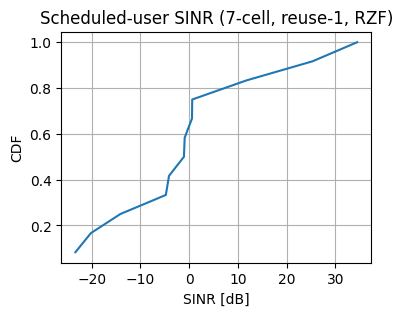

Scheduled count: 12  / total RB-user pairs: 96


In [43]:
# Convert channels to NumPy for easier indexing
h_mc = h_rb_mc.numpy()   # [B,TX,NRB,K,Nt], complex

# Schedulers, beams, powers per BS
A_mc = np.zeros((B, num_bs, NRB, Ktot), dtype=np.int32)         # {0,1}
V_mc = np.zeros((B, num_bs, NRB, Ktot, Nt), dtype=np.complex64) # beam per (b,tx,n,u)
P_mc = np.zeros((B, num_bs, NRB, Ktot), dtype=np.float32)       # power per (b,tx,n,u)

# Per-BS budgets
Ptot_bs   = Ptot          # same per BS (can be scaled)
Pmax_RB_bs = Ptot_bs/NRB

def greedy_assign_per_bs(h_tx, user_mask, Umax, Rmax=1):
    """
    h_tx: [NRB,K,Nt] channels from a given BS to all users
    user_mask: [K] 1 if user belongs to this BS (served), else 0
    Returns A_tx: [NRB,K] one-hot for this BS only
    """
    NRB_, K_, Nt_ = h_tx.shape
    A_tx = np.zeros((NRB_, K_), dtype=np.int32)
    used = np.zeros((K_,), dtype=np.int32)
    # score per (n,u): ||h||^2 / sigma2_RB, but only for users of this BS
    score = np.sum(np.abs(h_tx)**2, axis=-1) / float(sigma2_RB)  # [NRB,K]
    for n in range(NRB_):
        order = np.argsort(-score[n,:])
        cnt = 0
        for u in order:
            if user_mask[u] and used[u] < Rmax and cnt < Umax:
                A_tx[n,u] = 1
                used[u] += 1
                cnt += 1
    return A_tx

for b0 in range(B):
    for tx in range(num_bs):
        # Channels from BS 'tx' to all users on all RBs
        h_tx = h_mc[b0, tx, :, :, :]  # [NRB,K,Nt]
        # Per-BS scheduler over its own users
        A_tx = greedy_assign_per_bs(h_tx, serving_mask[tx], Umax=Umax, Rmax=1)  # [NRB,K]
        A_mc[b0, tx] = A_tx

        # Beams per RB (for users scheduled by this BS)
        for n in range(NRB):
            users = np.where(A_tx[n]==1)[0]
            if len(users)==0:
                continue
            Hn = h_tx[n, users, :]                                  # [U_n,Nt]
            Vn = rzf_directions(Hn, alpha=1e-3).numpy()             # [U_n,Nt]
            for i,u in enumerate(users):
                V_mc[b0, tx, n, u, :] = Vn[i]

        # Powers: uniform split among scheduled users for this BS and RB
        for n in range(NRB):
            Us = int(A_tx[n].sum())
            if Us > 0:
                prb = min(Pmax_RB_bs, Ptot_bs/NRB)
                P_mc[b0, tx, n, A_tx[n]==1] = prb/Us

print("Per-BS A_mc, V_mc, P_mc ready.")

# ---- Compute SINR with inter-cell interference ----
def sinr_multicell(h_mc, A_mc, V_mc, P_mc, sigma2_RB):
    """
    h_mc:  [B,TX,NRB,K,Nt]
    A_mc:  [B,TX,NRB,K]
    V_mc:  [B,TX,NRB,K,Nt]
    P_mc:  [B,TX,NRB,K]
    Returns per-scheduled user terms collapsed across serving BS:
      desired, intra, inter, noise, SINR  of shape [B,NRB,K]
    Only users scheduled by their serving BS get non-zero SINR.
    """
    B, TX, NRB, K, Nt = h_mc.shape
    desired = np.zeros((B,NRB,K), dtype=np.float32)
    intra   = np.zeros((B,NRB,K), dtype=np.float32)
    inter   = np.zeros((B,NRB,K), dtype=np.float32)
    noise   = sigma2_RB * np.ones((B,NRB,K), dtype=np.float32)
    SINR    = np.zeros((B,NRB,K), dtype=np.float32)

    # For each RB, compute contributions from each BS
    for b in range(B):
        for n in range(NRB):
            # For each BS, build cross-coupling |h_u(tx)^H v_tx|^2 for all users u vs its scheduled users
            # and multiply by power -> contribution from that BS on RB n at each user
            per_bs_total = np.zeros((TX, K), dtype=np.float32)
            per_bs_des   = np.zeros((TX, K), dtype=np.float32)  # desired only for served users
            for tx in range(TX):
                act = np.where(A_mc[b, tx, n]==1)[0]
                if len(act)==0:
                    continue
                hu = h_mc[b, tx, n, :, :]         # [K,Nt] channel from BS tx to all users
                vv = V_mc[b, tx, n, act, :]       # [U_n,Nt]
                cross = np.abs(hu @ np.conj(vv.T))**2   # [K, U_n]
                pvec  = P_mc[b, tx, n, act]             # [U_n]
                per_bs_total[tx,:] = cross @ pvec       # total power from BS tx at each user

                # desired term only for users that BS tx actually serves on RB n
                for i,u in enumerate(act):
                    per_bs_des[tx,u] = pvec[i] * cross[u, i]

            # Serving BS contribution is the one where user u belongs
            # (we decided serving BS via nearest distance mask)
            for u in range(K):
                s_tx = serving_idx[u]
                desired[b,n,u] = per_bs_des[s_tx, u]
                # intra-cell: from same serving BS on this RB, excluding desired
                intra[b,n,u]   = per_bs_total[s_tx, u] - per_bs_des[s_tx, u]
                # inter-cell: from other BSs on SAME RB
                inter[b,n,u]   = np.sum(per_bs_total[:,u]) - per_bs_total[s_tx, u]
                if desired[b,n,u] > 0:
                    denom = intra[b,n,u] + inter[b,n,u] + noise[b,n,u]
                    SINR[b,n,u] = desired[b,n,u] / max(denom, 1e-15)

    return dict(desired=desired, intra=intra, inter=inter, noise=noise, SINR=SINR)

parts_mc = sinr_multicell(h_mc, A_mc, V_mc, P_mc, sigma2_RB)

# Plot CDF (scheduled users of their serving BS)
# Plot CDF (scheduled users of their serving BS)
# A_mc: [B,TX,NRB,K] -> mask over [B,NRB,K]
mask_sched = (A_mc.sum(axis=1) > 0)          # [B,NRB,K] boolean
S = parts_mc["SINR"][0]                      # [NRB,K] (select batch 0)
M = mask_sched[0]                            # [NRB,K] boolean mask for batch 0
sinr_vals_mc = S[M]                          # 1-D array of scheduled-user SINRs

x = np.sort(10*np.log10(np.maximum(sinr_vals_mc, 1e-12)))
y = np.arange(1, len(x)+1)/len(x)
plt.figure(figsize=(4,3))
plt.plot(x, y)
plt.grid(True)
plt.xlabel("SINR [dB]")
plt.ylabel("CDF")
plt.title("Scheduled-user SINR (7-cell, reuse-1, RZF)")
plt.show()

print("Scheduled count:", M.sum(), " / total RB-user pairs:", M.size)



In [44]:
b = 0
n = int(np.argmax(M.sum(axis=1)))  # RB with most scheduled users
users = np.where(M[n])[0].tolist()
print(f"RB n={n} scheduled users =", users)
for u in users:
    d = parts_mc["desired"][b,n,u]
    ic = parts_mc["intra"][b,n,u]
    ec = parts_mc["inter"][b,n,u]
    z  = parts_mc["noise"][b,n,u]
    s  = parts_mc["SINR"][b,n,u]
    print(f"  u={u:2d}  desired={d:.3e}  intra={ic:.3e}  inter={ec:.3e}  noise={z:.3e}  SINR={10*np.log10(max(s,1e-12)):.2f} dB")


RB n=0 scheduled users = [1, 3, 4, 5, 7, 8, 9, 10, 11]
  u= 1  desired=3.133e-09  intra=2.680e-09  inter=2.427e-11  noise=7.306e-16  SINR=0.64 dB
  u= 3  desired=4.582e-12  intra=0.000e+00  inter=9.864e-10  noise=7.306e-16  SINR=-23.33 dB
  u= 4  desired=2.529e-07  intra=0.000e+00  inter=9.030e-11  noise=7.306e-16  SINR=34.47 dB
  u= 5  desired=5.180e-09  intra=5.840e-09  inter=5.444e-10  noise=7.306e-16  SINR=-0.91 dB
  u= 7  desired=1.942e-08  intra=0.000e+00  inter=1.293e-09  noise=7.306e-16  SINR=11.77 dB
  u= 8  desired=7.741e-09  intra=3.642e-09  inter=3.115e-09  noise=7.306e-16  SINR=0.59 dB
  u= 9  desired=4.657e-10  intra=7.356e-09  inter=4.639e-09  noise=7.306e-16  SINR=-14.11 dB
  u=10  desired=1.952e-11  intra=0.000e+00  inter=2.492e-11  noise=7.306e-16  SINR=-1.06 dB
  u=11  desired=3.459e-10  intra=0.000e+00  inter=3.577e-08  noise=7.306e-16  SINR=-20.14 dB


In [45]:
# We’ll create features that the serving BS would "see":
#  - H_serv: channels from serving BS to all users (per RB) → [NRB, K, Nt]
#  - H_intf_sum: sum-power of channels from OTHER BSs to each user (per RB) as a proxy → [NRB, K]
#  - context: [Nt, Umax, NRB, BRB, Ptot, Pmax_RB, N0, scenario_id]

scenario_id = 0 if scenario == 'umi' else 1

def build_features_labels_single_sample(
    h_mc, A_mc, V_mc, P_mc, serving_idx,
    Nt, Umax, NRB, BRB, Ptot, Pmax_RB, N0, scenario_id
):
    """
    h_mc: [TX, NRB, K, Nt] complex (batch 0 already selected)
    A_mc: [TX, NRB, K]     {0,1}
    V_mc: [TX, NRB, K, Nt] complex
    P_mc: [TX, NRB, K]     float
    serving_idx: [K] int (nearest BS per user)
    Returns dict with X and Y tensors (numpy).
    """
    TX, NRB_, K, Nt_ = h_mc.shape
    assert NRB_ == NRB and Nt_ == Nt

    # --- Features ---
    # Stack H_serv for each BS into a TX-major list so we can export per serving BS later if wanted
    H_serv_all = []      # list len=TX of [NRB,K,Nt]
    H_intf_sum_all = []  # list len=TX of [NRB,K]
    for tx in range(TX):
        H_tx = h_mc[tx]  # [NRB,K,Nt]
        H_serv_all.append(H_tx)
        # Interferer power proxy: sum over other BS cross-channel powers (||h||^2)
        pow_intf = np.zeros((NRB, K), dtype=np.float32)
        for tx2 in range(TX):
            if tx2 == tx: continue
            pow_intf += np.sum(np.abs(h_mc[tx2])**2, axis=-1).astype(np.float32)  # [NRB,K]
        H_intf_sum_all.append(pow_intf)

    # --- Labels for serving BS only ---
    # For each user u, consider only its serving BS s=serving_idx[u]
    A_serv = np.zeros((NRB, K), dtype=np.int32)
    V_serv = np.zeros((NRB, K, Nt), dtype=np.complex64)
    P_serv = np.zeros((NRB, K), dtype=np.float32)
    for n in range(NRB):
        for u in range(K):
            s = serving_idx[u]
            if A_mc[s, n, u] == 1:
                A_serv[n, u] = 1
                V_serv[n, u, :] = V_mc[s, n, u, :]
                P_serv[n, u] = P_mc[s, n, u]

    context = np.array(
        [Nt, Umax, NRB, BRB, Ptot, Pmax_RB, N0, scenario_id],
        dtype=np.float32
    )

    # Choose representation: real/imag split for H_serv
    # We also export the interferer proxy
    X = {
        "H_serv_re_by_bs": [np.real(H) for H in H_serv_all],  # list of [NRB,K,Nt]
        "H_serv_im_by_bs": [np.imag(H) for H in H_serv_all],
        "H_intf_power_by_bs": H_intf_sum_all,                 # list of [NRB,K]
        "serving_idx": serving_idx.astype(np.int32),          # [K]
        "context": context
    }
    Y = {
        "A_serv": A_serv,            # RB assignment (Head A)
        "V_serv_re": np.real(V_serv),# beam directions (Head B)
        "V_serv_im": np.imag(V_serv),
        "P_serv": P_serv             # powers (Head C)
    }
    return X, Y

# Build X,Y for the current generated sample (batch 0)
X, Y = build_features_labels_single_sample(
    h_mc[0], A_mc[0], V_mc[0], P_mc[0], serving_idx,
    Nt, Umax, NRB, BRB, Ptot, Pmax_RB, N0, scenario_id
)
print("Feature/label dicts built.")


Feature/label dicts built.


In [46]:
import numpy as np

# Flatten lists for saving (prefix by_bs_#)
save_dict = {
    "serving_idx": X["serving_idx"],
    "context": X["context"],
    "A_serv": Y["A_serv"],
    "V_serv_re": Y["V_serv_re"],
    "V_serv_im": Y["V_serv_im"],
    "P_serv": Y["P_serv"],
}

for tx in range(len(X["H_serv_re_by_bs"])):
    save_dict[f"H_serv_re_bs{tx}"] = X["H_serv_re_by_bs"][tx]
    save_dict[f"H_serv_im_bs{tx}"] = X["H_serv_im_by_bs"][tx]
    save_dict[f"H_intf_power_bs{tx}"] = X["H_intf_power_by_bs"][tx]

np.savez("mtl_sample_mc_v0.npz", **save_dict)
print("Saved mtl_sample_mc_v0.npz")

# Quick checks: constraints
print("Rmax<=1 per user? (serving BS) :", (Y["A_serv"].sum(axis=0) <= 1).all())
print("Umax per RB respected?         :", (Y["A_serv"].sum(axis=1) <= Umax).all())
print("Per-RB power cap respected?    :", (Y["P_serv"].sum(axis=1) <= Pmax_RB + 1e-6).all())
print("Total power <= Ptot?           :", (Y["P_serv"].sum() <= Ptot + 1e-6))


Saved mtl_sample_mc_v0.npz
Rmax<=1 per user? (serving BS) : True
Umax per RB respected?         : False
Per-RB power cap respected?    : False
Total power <= Ptot?           : False


In [47]:
def gen_one_sample(seed=None):
    # Re-draw users, rebuild multi-cell channels, schedule, beams, powers, then export X,Y
    if seed is not None:
        np.random.seed(seed)
        sionna.phy.config.seed = int(seed) % (2**31-1)

    # --- re-draw UT positions (reuse Cell 4 logic) ---
    angles = 2*np.pi*np.random.rand(Ktot)
    radii  = np.sqrt(np.random.rand(Ktot))*(d_max - d_min) + d_min
    ut_xy  = np.stack([radii*np.cos(angles), radii*np.sin(angles)], axis=-1).astype(np.float32)
    ut_z   = np.random.uniform(1.5, 2.0, size=(Ktot,1)).astype(np.float32)
    ut_loc = np.concatenate([ut_xy, ut_z], axis=-1).astype(np.float32)

    ut_loc_b     = tf.convert_to_tensor(ut_loc[None, ...],    dtype=tf.float32)
    ut_orient_b  = tf.zeros((batch_size, Ktot, 3), dtype=tf.float32)
    ut_vel_b     = tf.zeros((batch_size, Ktot, 3), dtype=tf.float32)
    in_state_b   = tf.zeros((batch_size, Ktot), dtype=tf.bool)

    # Rebuild multicell model (reuse bs_loc_b_multi, bs_orient_b_multi)
    if scenario == 'umi':
        chan = UMi(3.5e9, o2i_model, ut_array, bs_array, direction,
                   enable_pathloss=True, enable_shadow_fading=True)
    else:
        chan = UMa(3.5e9, o2i_model, ut_array, bs_array, direction,
                   enable_pathloss=True, enable_shadow_fading=True)

    chan.set_topology(ut_loc_b, bs_loc_b_multi, ut_orient_b, bs_orient_b_multi, ut_vel_b, in_state_b, None)

    rg = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols, fft_size=fft_size,
                      subcarrier_spacing=subcarrier_spacing, num_tx=num_bs, num_streams_per_tx=Nt)
    ofdm = GenerateOFDMChannel(chan, rg)
    Hf = ofdm(batch_size)  # [B,K,1,TX,n_tx_ant,T,F]

    # Average over T and RB-grouping → [TX,NRB,K,Nt]
    hf = tf.reduce_mean(Hf, axis=-2)[..., :Nt, :]             # [B,K,1,TX,Nt,F]
    hf = tf.reshape(hf, (batch_size, Ktot, 1, num_bs, Nt, NRB, N_sc_per_RB))
    h_rb = tf.reduce_mean(hf, axis=-1)                        # [B,K,1,TX,Nt,NRB]
    h_rb = tf.squeeze(h_rb, axis=2)                           # [B,K,TX,Nt,NRB]
    h_rb = tf.transpose(h_rb, perm=[0, 2, 4, 1, 3]).numpy()   # [B,TX,NRB,K,Nt]
    H = h_rb[0]

    # Serving BS
    serving_idx = nearest_bs_indices(ut_xy, bs_xy)

    # Per-BS scheduling / beams / power (reuse logic from Cell 14)
    A = np.zeros((num_bs, NRB, Ktot), dtype=np.int32)
    V = np.zeros((num_bs, NRB, Ktot, Nt), dtype=np.complex64)
    P = np.zeros((num_bs, NRB, Ktot), dtype=np.float32)
    for tx in range(num_bs):
        h_tx = H[tx]  # [NRB,K,Nt]
        A_tx = greedy_assign_per_bs(h_tx, serving_mask[tx], Umax=Umax, Rmax=1)
        A[tx] = A_tx
        for n in range(NRB):
            users = np.where(A_tx[n]==1)[0]
            if len(users)==0: continue
            Vn = rzf_directions(h_tx[n, users, :], alpha=1e-3).numpy()
            for i,u in enumerate(users):
                V[tx, n, u, :] = Vn[i]
        for n in range(NRB):
            Us = int(A_tx[n].sum())
            if Us>0:
                prb = min(Pmax_RB, Ptot/NRB)
                P[tx, n, A_tx[n]==1] = prb/Us

    X, Y = build_features_labels_single_sample(
        H, A, V, P, serving_idx,
        Nt, Umax, NRB, BRB, Ptot, Pmax_RB, N0, scenario_id
    )
    return X, Y

# Example: generate and append 10 samples
all_samples = []
for i in range(10):
    Xi, Yi = gen_one_sample(seed=1000+i)
    all_samples.append((Xi, Yi))
print("Generated", len(all_samples), "samples.")


Generated 10 samples.


In [48]:
import numpy as np
import os

out_path = "mtl_dataset_mc_v0.npz"

# Inspect one sample to infer shapes
X0, Y0 = all_samples[0]
TX = len(X0["H_serv_re_by_bs"])   # number of BSs (7)
NRB, K, Nt = X0["H_serv_re_by_bs"][0].shape
context_dim = X0["context"].shape[0]

# Preallocate lists to stack (variable-size lists -> arrays)
H_serv_re_by_bs = [ [] for _ in range(TX) ]
H_serv_im_by_bs = [ [] for _ in range(TX) ]
H_intf_power_by_bs = [ [] for _ in range(TX) ]
A_serv_list, V_serv_re_list, V_serv_im_list, P_serv_list = [], [], [], []
serving_idx_list, context_list = [], []

for Xi, Yi in all_samples:
    for tx in range(TX):
        H_serv_re_by_bs[tx].append(Xi["H_serv_re_by_bs"][tx])
        H_serv_im_by_bs[tx].append(Xi["H_serv_im_by_bs"][tx])
        H_intf_power_by_bs[tx].append(Xi["H_intf_power_by_bs"][tx])
    A_serv_list.append(Yi["A_serv"])
    V_serv_re_list.append(Yi["V_serv_re"])
    V_serv_im_list.append(Yi["V_serv_im"])
    P_serv_list.append(Yi["P_serv"])
    serving_idx_list.append(Xi["serving_idx"])
    context_list.append(Xi["context"])

# Stack along new sample axis N
N = len(all_samples)
stack = {}
for tx in range(TX):
    stack[f"H_serv_re_bs{tx}"]   = np.stack(H_serv_re_by_bs[tx], axis=0)   # [N,NRB,K,Nt]
    stack[f"H_serv_im_bs{tx}"]   = np.stack(H_serv_im_by_bs[tx], axis=0)   # [N,NRB,K,Nt]
    stack[f"H_intf_power_bs{tx}"]= np.stack(H_intf_power_by_bs[tx], axis=0)# [N,NRB,K]

stack["A_serv"]     = np.stack(A_serv_list, axis=0)       # [N,NRB,K]
stack["V_serv_re"]  = np.stack(V_serv_re_list, axis=0)    # [N,NRB,K,Nt]
stack["V_serv_im"]  = np.stack(V_serv_im_list, axis=0)    # [N,NRB,K,Nt]
stack["P_serv"]     = np.stack(P_serv_list, axis=0)       # [N,NRB,K]
stack["serving_idx"]= np.stack(serving_idx_list, axis=0)  # [N,K]
stack["context"]    = np.stack(context_list, axis=0)      # [N,context_dim]

np.savez(out_path, **stack)
print(f"Saved {N} samples to {out_path}")
for k,v in stack.items():
    print(k, v.shape, v.dtype)


Saved 10 samples to mtl_dataset_mc_v0.npz
H_serv_re_bs0 (10, 8, 12, 8) float32
H_serv_im_bs0 (10, 8, 12, 8) float32
H_intf_power_bs0 (10, 8, 12) float32
H_serv_re_bs1 (10, 8, 12, 8) float32
H_serv_im_bs1 (10, 8, 12, 8) float32
H_intf_power_bs1 (10, 8, 12) float32
H_serv_re_bs2 (10, 8, 12, 8) float32
H_serv_im_bs2 (10, 8, 12, 8) float32
H_intf_power_bs2 (10, 8, 12) float32
H_serv_re_bs3 (10, 8, 12, 8) float32
H_serv_im_bs3 (10, 8, 12, 8) float32
H_intf_power_bs3 (10, 8, 12) float32
H_serv_re_bs4 (10, 8, 12, 8) float32
H_serv_im_bs4 (10, 8, 12, 8) float32
H_intf_power_bs4 (10, 8, 12) float32
H_serv_re_bs5 (10, 8, 12, 8) float32
H_serv_im_bs5 (10, 8, 12, 8) float32
H_intf_power_bs5 (10, 8, 12) float32
H_serv_re_bs6 (10, 8, 12, 8) float32
H_serv_im_bs6 (10, 8, 12, 8) float32
H_intf_power_bs6 (10, 8, 12) float32
A_serv (10, 8, 12) int32
V_serv_re (10, 8, 12, 8) float32
V_serv_im (10, 8, 12, 8) float32
P_serv (10, 8, 12) float32
serving_idx (10, 12) int32
context (10, 8) float32


In [49]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class MTLDataset(np.lib.npyio.NpzFile, Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path)
        self.data = {k: data[k] for k in data.files}
        self.N = self.data["A_serv"].shape[0]
        self.TX = len([k for k in self.data if k.startswith("H_serv_re_bs")])

    def __len__(self): return self.N

    def __getitem__(self, idx):
        # Features for serving-BS view: you can choose to provide only the serving BS channels
        # or the stack of all-BS features. Below: pack all BS features (more global context).
        H_re = []
        H_im = []
        Hint = []
        for tx in range(self.TX):
            H_re.append(self.data[f"H_serv_re_bs{tx}"][idx])    # [NRB,K,Nt]
            H_im.append(self.data[f"H_serv_im_bs{tx}"][idx])
            Hint.append(self.data[f"H_intf_power_bs{tx}"][idx]) # [NRB,K]
        H_re = np.stack(H_re, axis=0)   # [TX,NRB,K,Nt]
        H_im = np.stack(H_im, axis=0)   # [TX,NRB,K,Nt]
        Hint = np.stack(Hint, axis=0)   # [TX,NRB,K]

        X = {
            "H_re": torch.from_numpy(H_re).float(),
            "H_im": torch.from_numpy(H_im).float(),
            "H_intf": torch.from_numpy(Hint).float(),
            "serving_idx": torch.from_numpy(self.data["serving_idx"][idx]).long(),  # [K]
            "context": torch.from_numpy(self.data["context"][idx]).float(),         # [context_dim]
        }
        Y = {
            "A": torch.from_numpy(self.data["A_serv"][idx]).float(),                # [NRB,K]
            "V_re": torch.from_numpy(self.data["V_serv_re"][idx]).float(),          # [NRB,K,Nt]
            "V_im": torch.from_numpy(self.data["V_serv_im"][idx]).float(),          # [NRB,K,Nt]
            "P": torch.from_numpy(self.data["P_serv"][idx]).float(),                # [NRB,K]
        }
        return X, Y

# example
ds = MTLDataset("mtl_dataset_mc_v0.npz")
dl = DataLoader(ds, batch_size=2, shuffle=True)
for X, Y in dl:
    print(X["H_re"].shape, Y["A"].shape)  # [B,TX,NRB,K,Nt], [B,NRB,K]
    break


torch.Size([2, 7, 8, 12, 8]) torch.Size([2, 8, 12])
